[Swin Transformer from Scratch in PyTorch](https://www.youtube.com/watch?v=LxPDpAiyqSU&list=PL9iXGo3xD8jokWaLB8ZHUkjjv5Y_vPQnZ)

[Github Swin Transformer Implementation](https://github.com/berniwal/swin-transformer-pytorch/blob/master/swin_transformer_pytorch/swin_transformer.py)

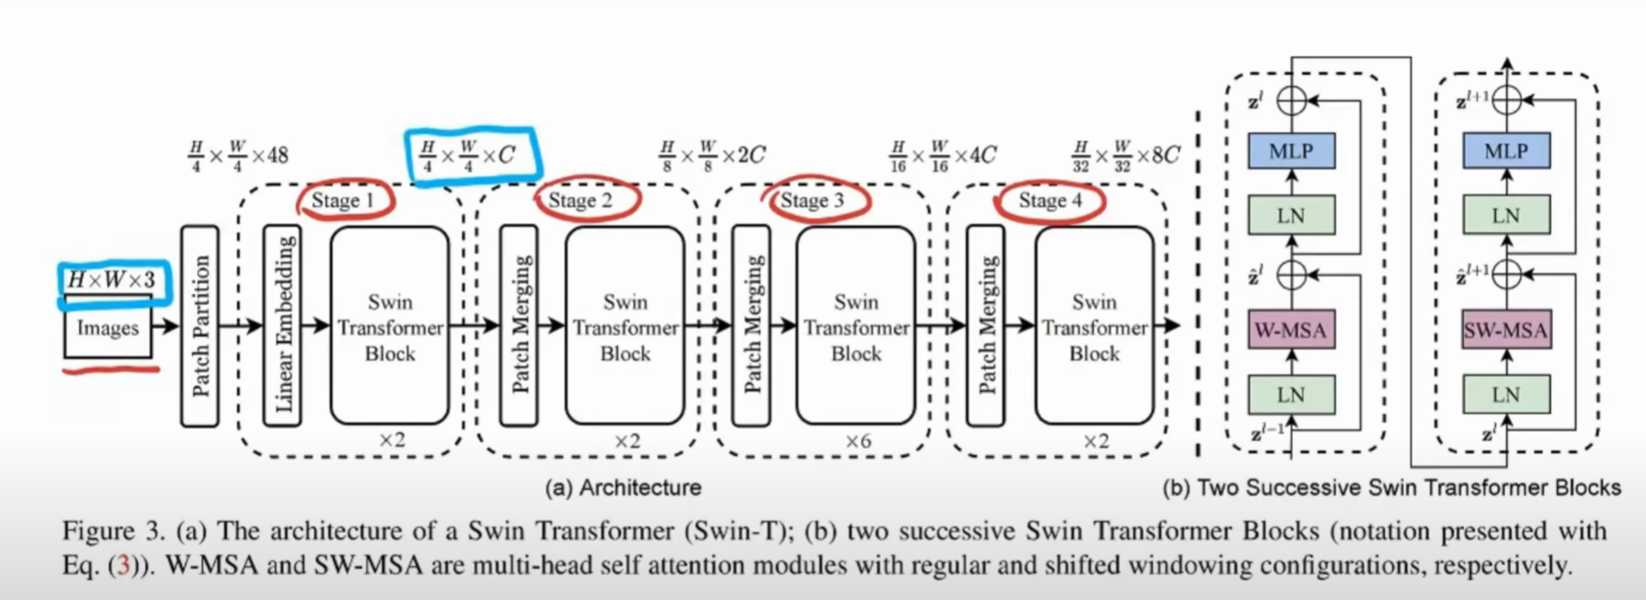

As we move forward, the size is shrinking, channel number is increasing. Total pixel number stays the same.

But there is no ralation between windows. So we use shift window to make them relatable in different stages.

At the same time, all windows shift right and down by half of the windows size. If window size is 7, shift right and down by 3 pixels. 

$$
d = \frac{\omega}{2}
$$

We can assume window size to be 7.

Down scale factor applies to each stage. Say down scale factor is (4,2,2,2), then the original image shape is [224,224], in stage 1 it is [56,56]

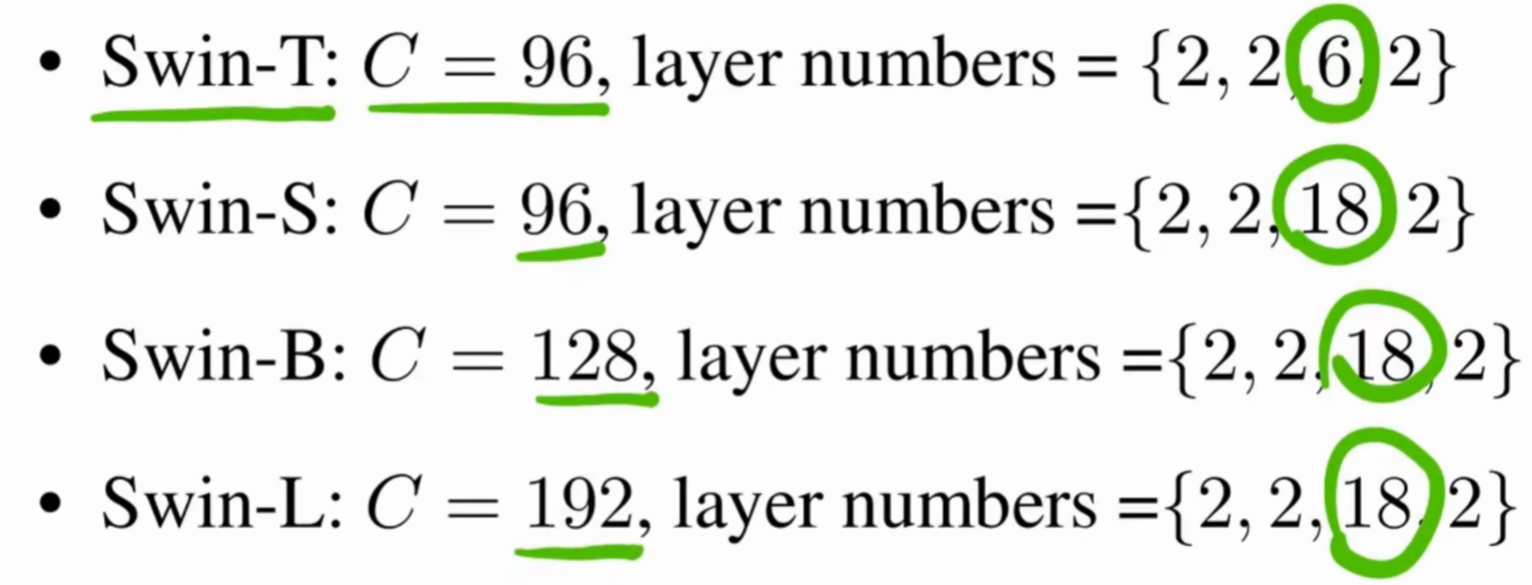

In [1]:
from torch import nn
import numpy as np
from einops import rearrange, repeat, einsum
import torch

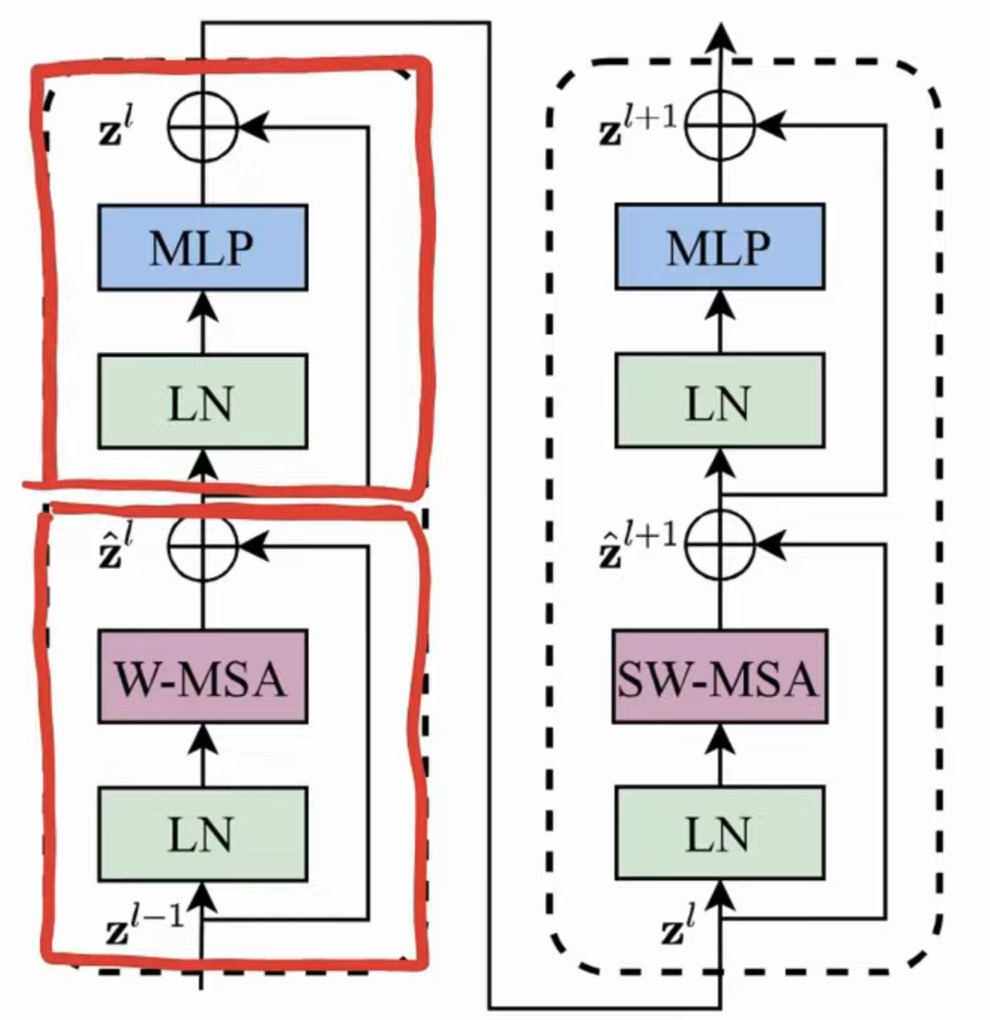

In [2]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


class PreNorm(nn.Module):
    """Decorator Pattern"""
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.fn(self.norm(x))


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

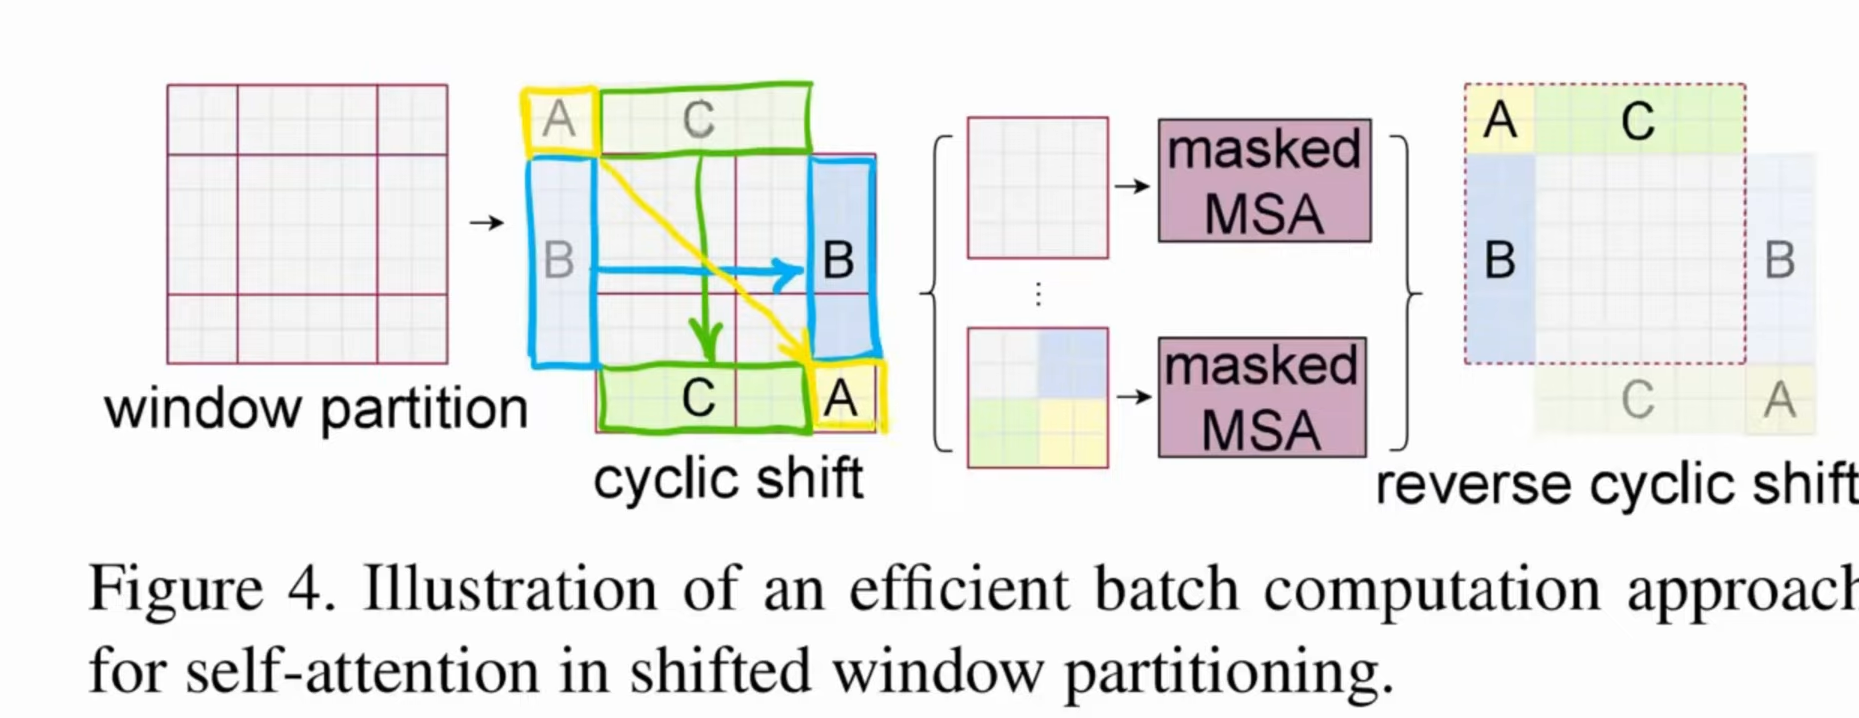

In [3]:
class CyclicShift(nn.Module):
    """Input x shape: [B, H, W, C]"""
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        # https://pytorch.org/docs/stable/generated/torch.roll.html
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))

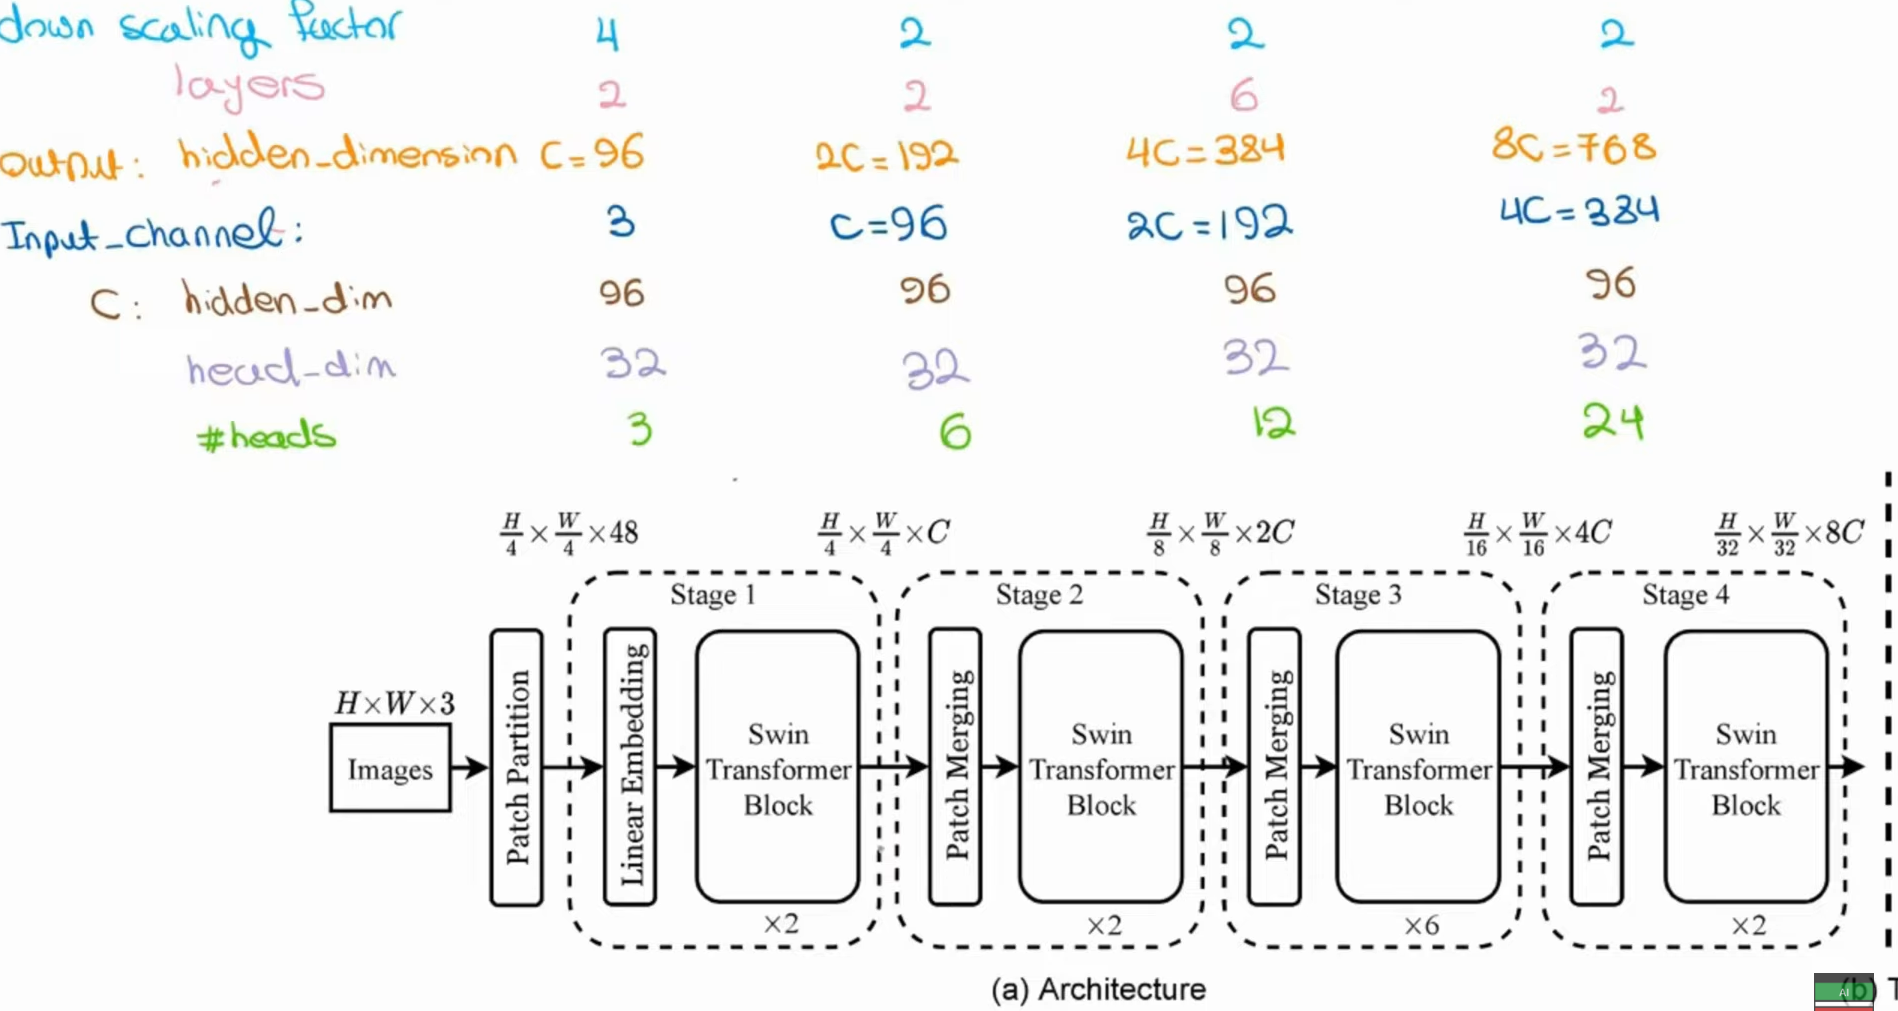

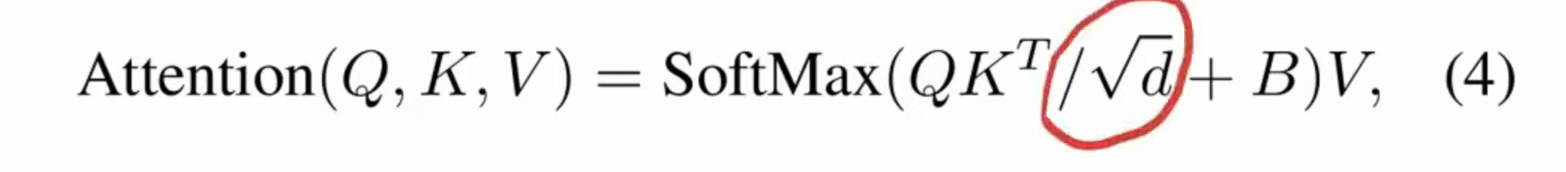

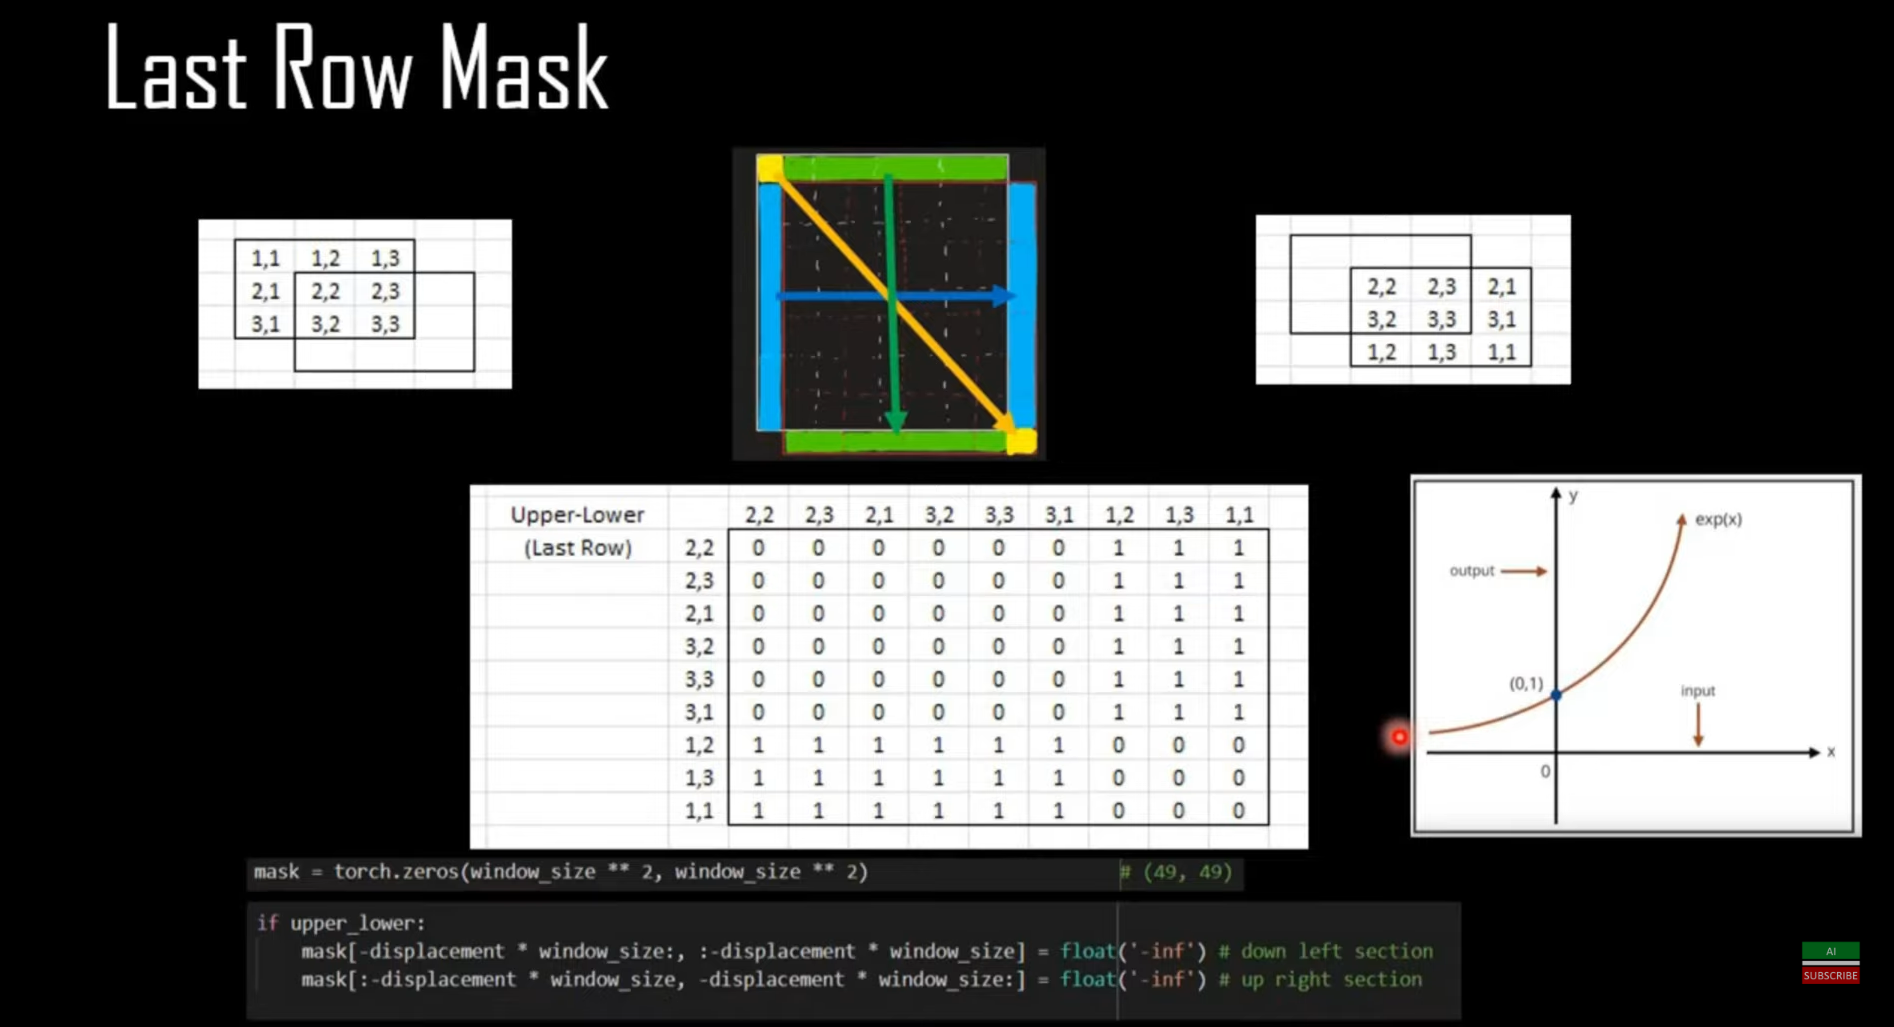

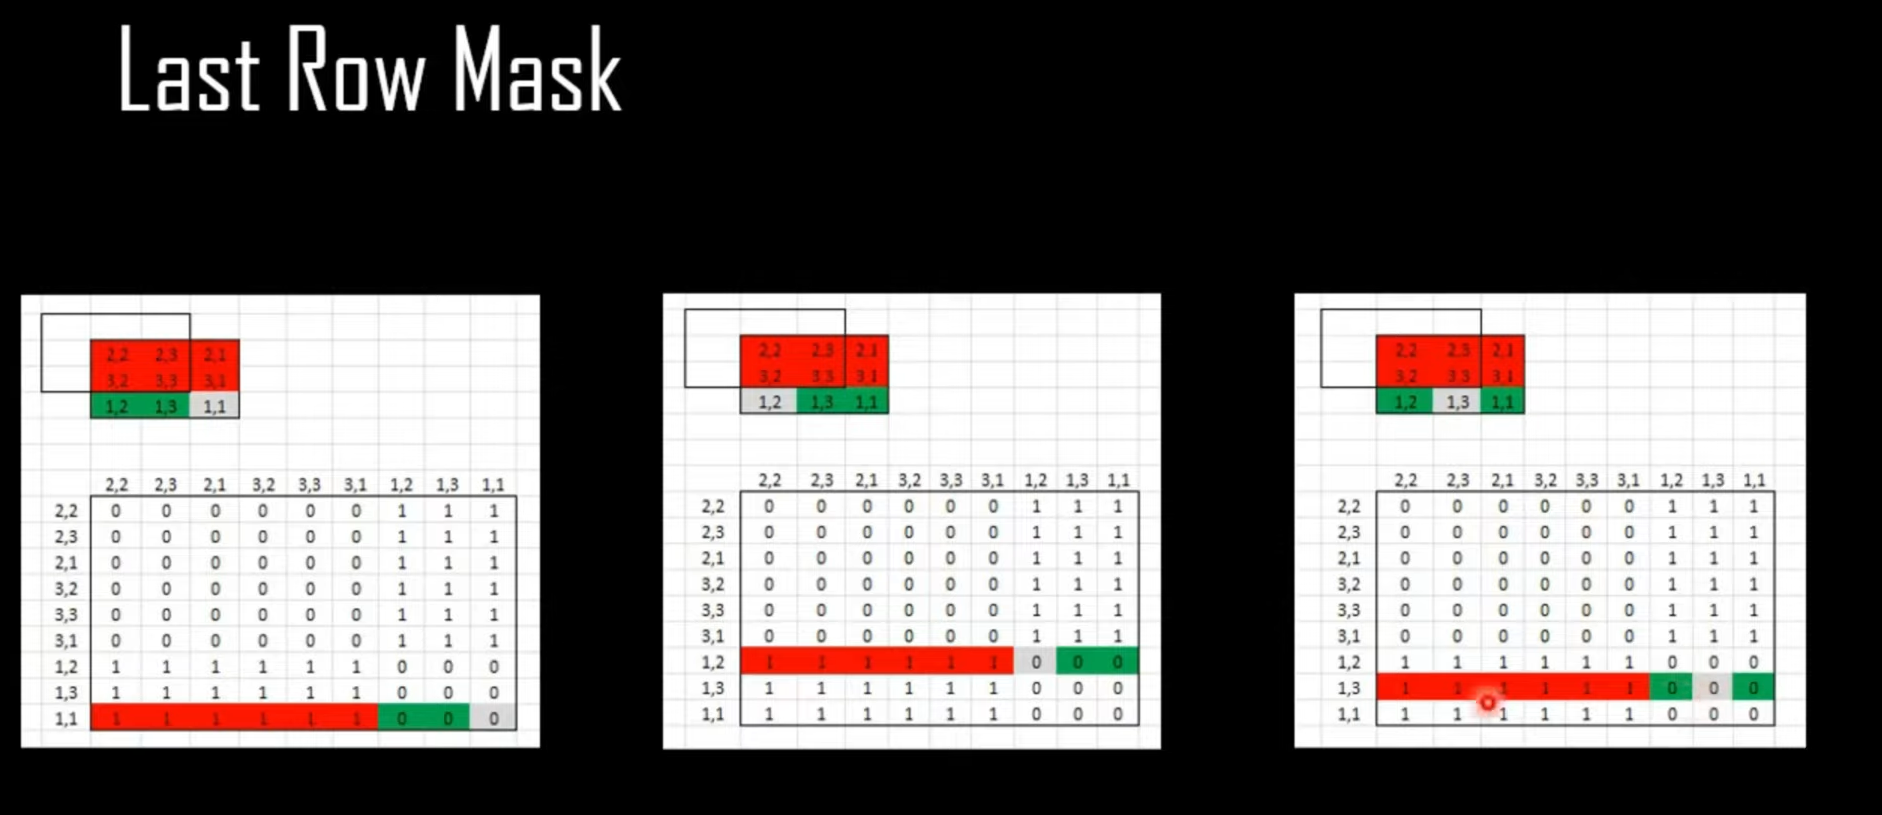

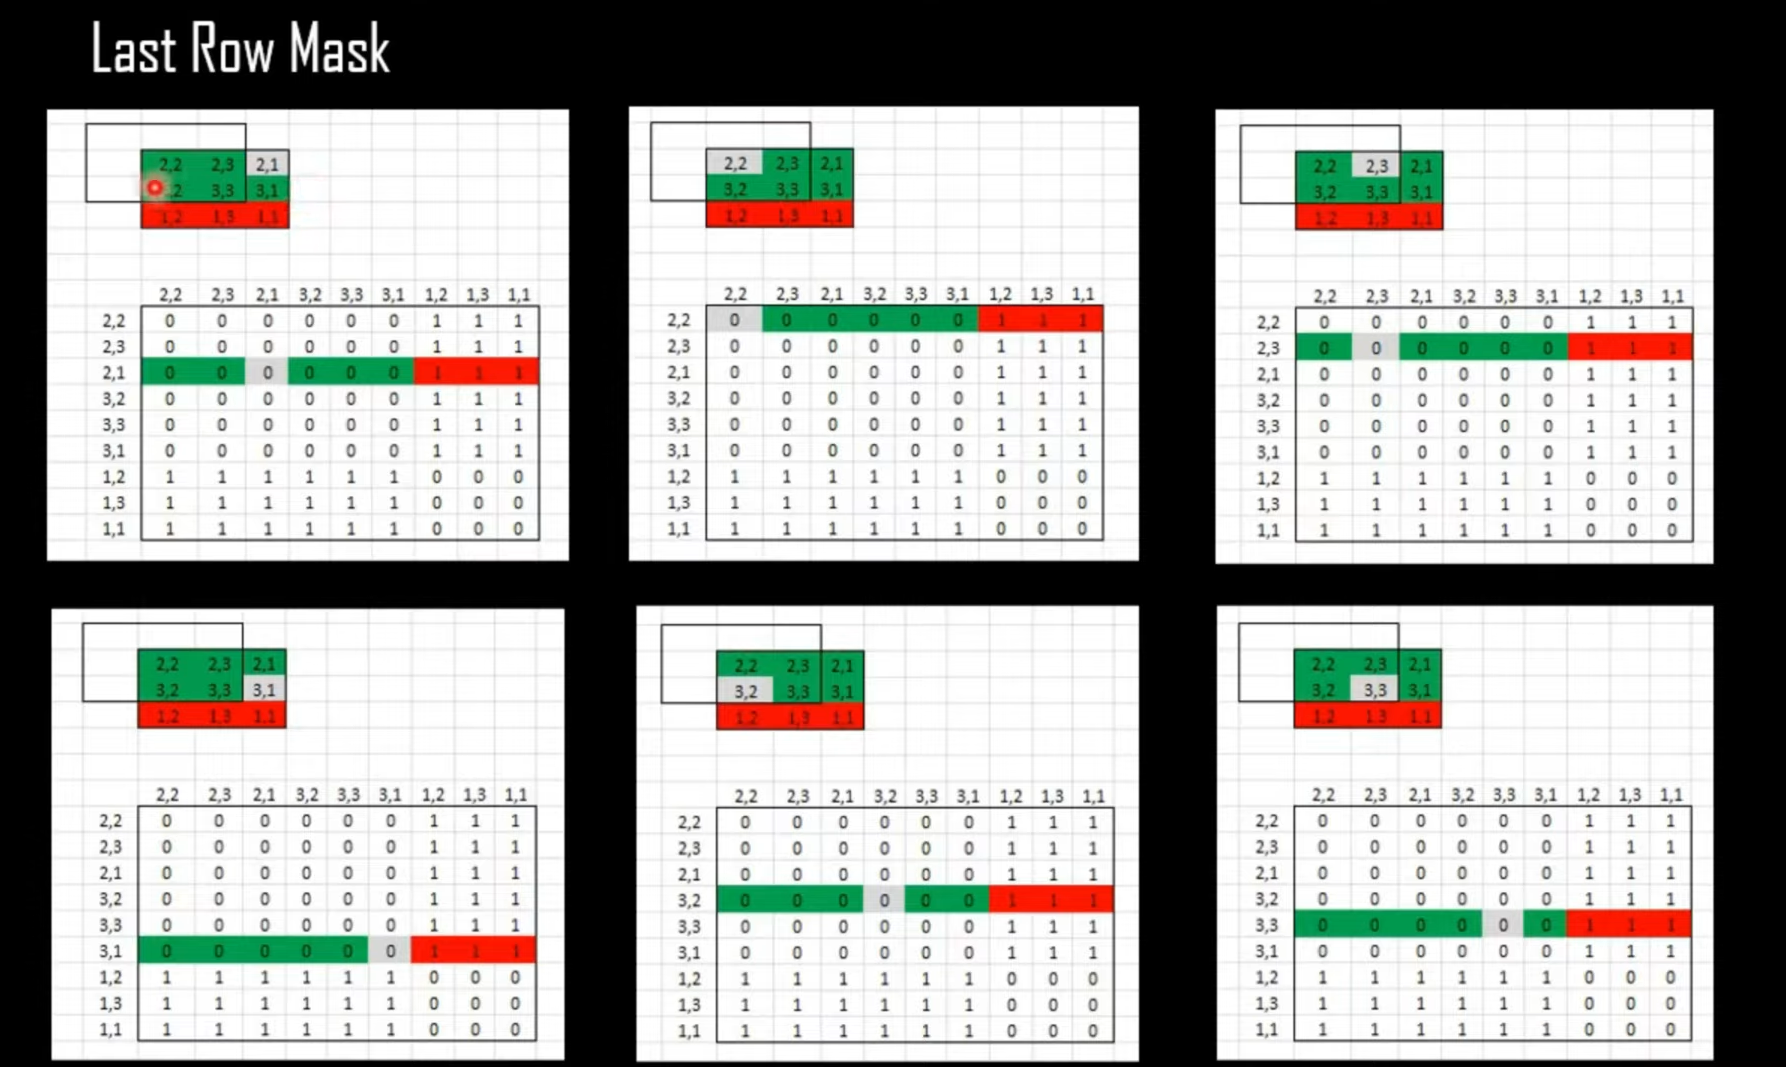

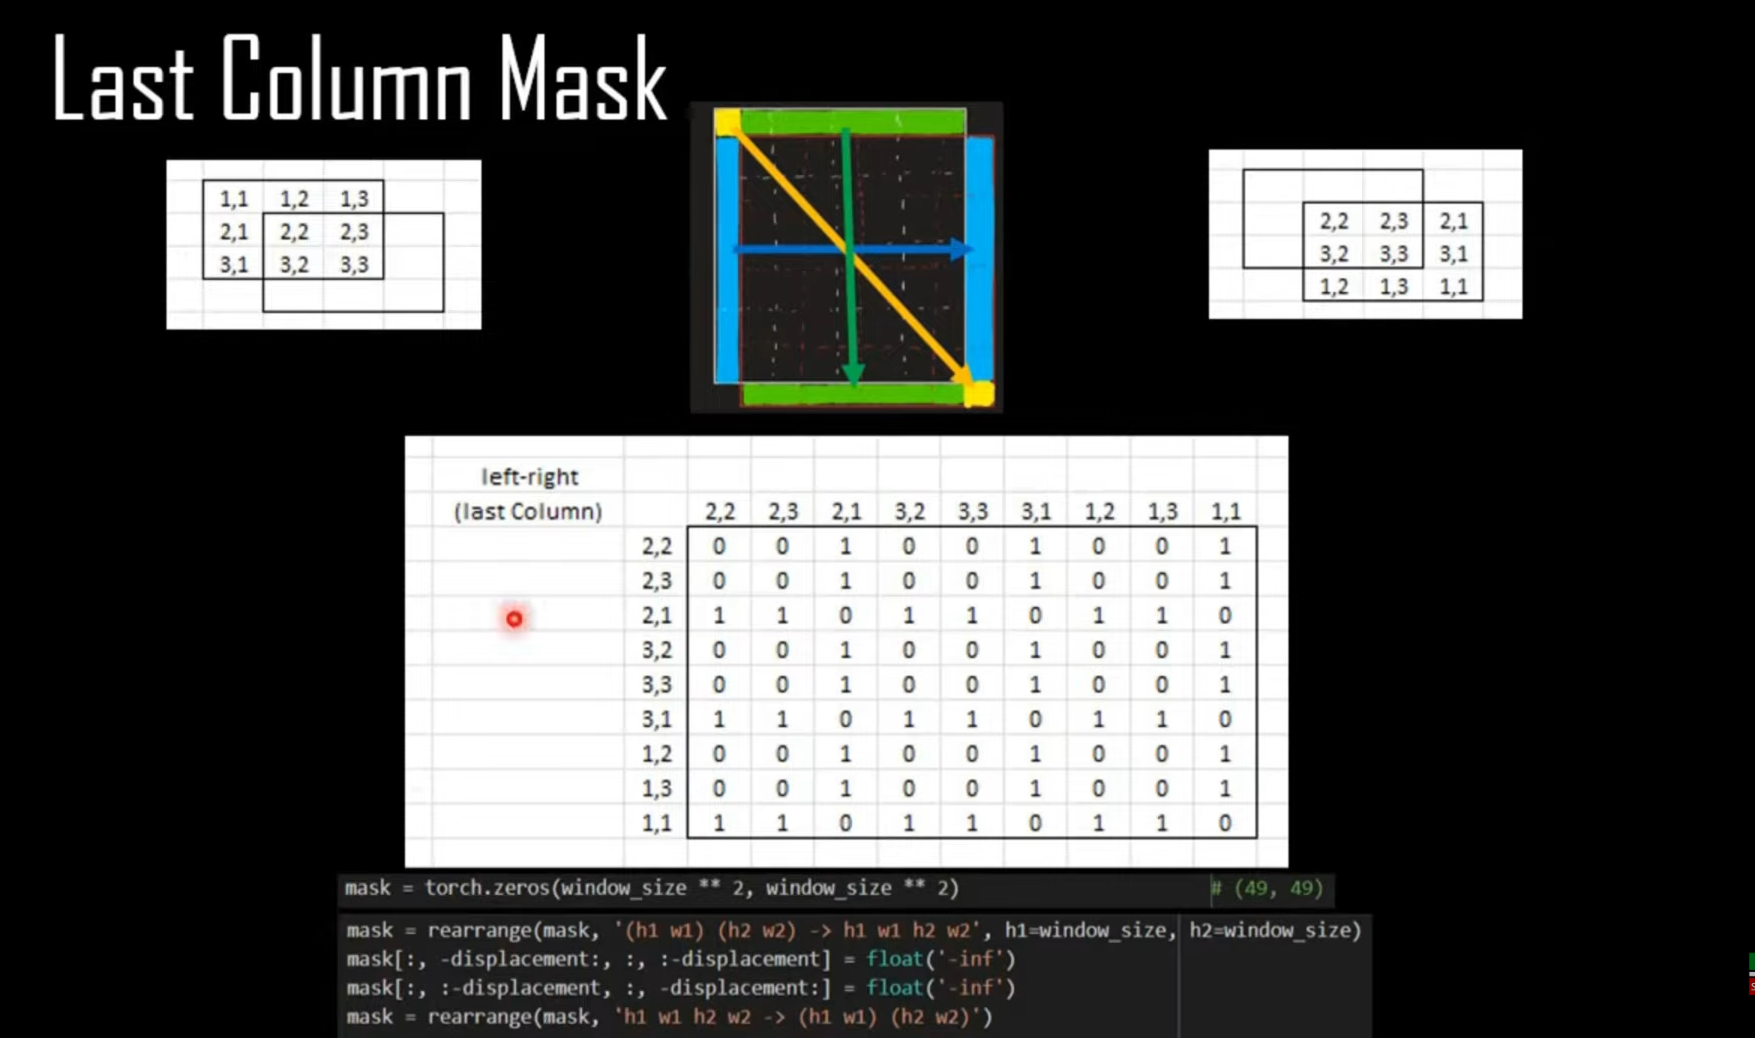

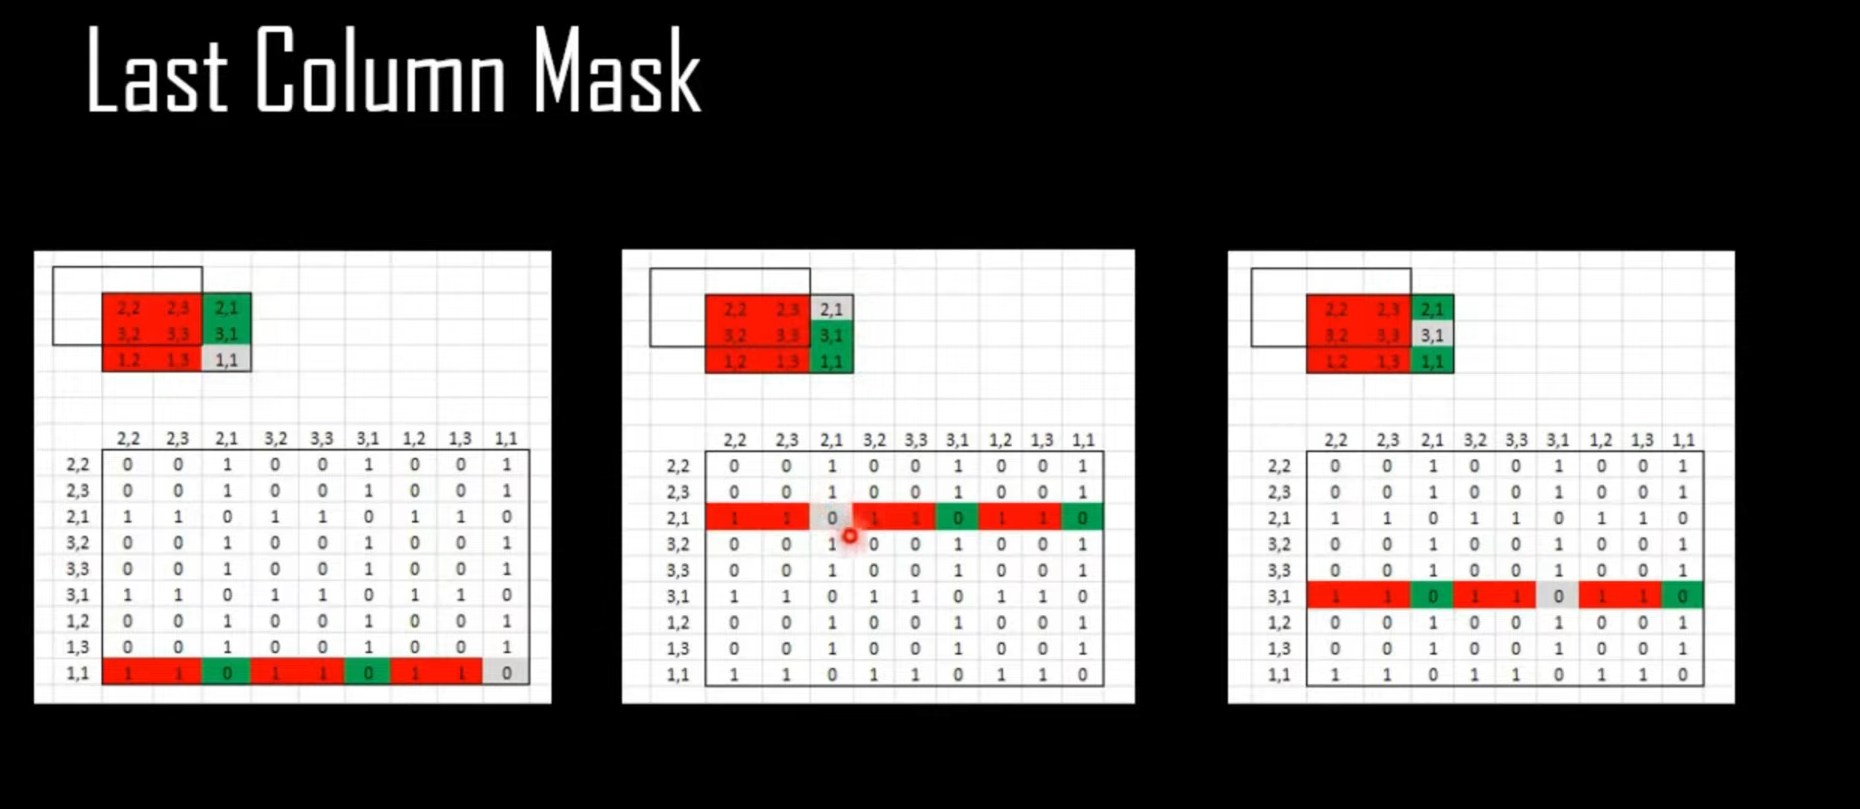

In [4]:
def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)  # [49, 49]
    # Partition the mask matrix into four parts
    # [1, 2]
    # [3, 4]

    if upper_lower:
        mask[-displacement * window_size:, :-displacement *
             window_size] = float('-inf')  # part 3
        mask[:-displacement * window_size, -displacement *
             window_size:] = float('-inf')  # part 2

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2',
                         h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask

In [5]:
create_mask(window_size=3, displacement=1, upper_lower=False, left_right=True)

tensor([[0., 0., -inf, 0., 0., -inf, 0., 0., -inf],
        [0., 0., -inf, 0., 0., -inf, 0., 0., -inf],
        [-inf, -inf, 0., -inf, -inf, 0., -inf, -inf, 0.],
        [0., 0., -inf, 0., 0., -inf, 0., 0., -inf],
        [0., 0., -inf, 0., 0., -inf, 0., 0., -inf],
        [-inf, -inf, 0., -inf, -inf, 0., -inf, -inf, 0.],
        [0., 0., -inf, 0., 0., -inf, 0., 0., -inf],
        [0., 0., -inf, 0., 0., -inf, 0., 0., -inf],
        [-inf, -inf, 0., -inf, -inf, 0., -inf, -inf, 0.]])

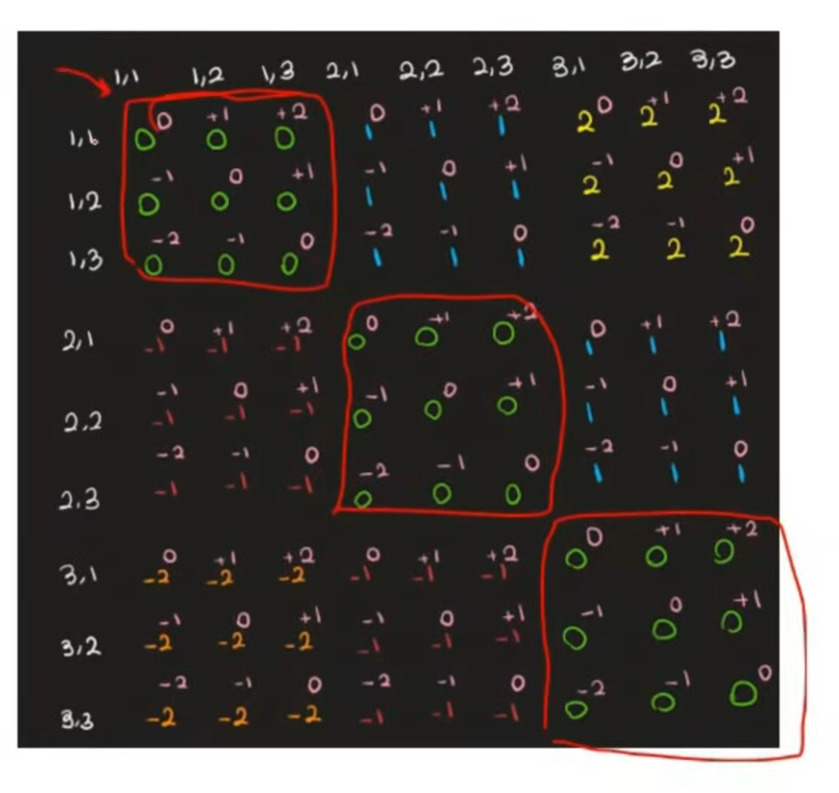

In [25]:
def get_relative_distances(window_size):
    indices = torch.tensor(
        np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    # print(indices)
    # print(indices[None, :, :])
    # print(indices[:, None, :])
    distances = indices[None, :, :] - indices[:, None, :]
    # print(distances[:, :, 0])
    # print(distances.shape)

    return distances


d = get_relative_distances(2)

In [26]:
indices = np.array([0, 0, 1, 1])
print(indices[None, :] - indices[:, None])

[[ 0  0  1  1]
 [ 0  0  1  1]
 [-1 -1  0  0]
 [-1 -1  0  0]]


In [7]:
class WindowAttention(nn.Module):
    """
    shifted: regular or shifted block
    dim = hidden_dim = [96, 192, 384, 768]
    heads = num_heads = [3,6,12,24]
    head_dim = 32
    """

    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5  # sqrt d
        self.window_size = window_size  # 7
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted  # boolean

        if self.shifted:
            # Shift all windows to the right and down by half of size of window
            # We need to pad the bottom most row and right most column
            # Cyclic padding is faster
            displacement = window_size // 2  # 7 // 2 = 3
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(
                create_mask(
                    window_size=window_size,
                    displacement=displacement,
                    upper_lower=True,
                    left_right=False),
                requires_grad=False)
            self.left_right_mask = nn.Parameter(
                create_mask(
                    window_size=window_size,
                    displacement=displacement,
                    upper_lower=False,
                    left_right=True),
                requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(
                window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(
                2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(
                torch.randn(window_size ** 2, window_size ** 2))  # [49， 49]

        # inner_dim = head_dim * heads = C, dim = hidden_dim = [96, 192, 384, 768]
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)
        # [B, [56, 28, 14, 7], [56, 28, 14, 7], [96, 192, 384, 768]]
        
        b, n_h, n_w, _, h = *x.shape, self.heads  # n_h, n_w are pixel numbers
        
        # self.to_qkv(x) last shape: [288, 576, 1152, 2304]
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        # qkv is tuple qkd[0] is Q
        # shape: [B, [56, 28, 14, 7], [56, 28, 14, 7], [96, 192, 384, 768]]
        nw_h = n_h // self.window_size  # number of windows on height/width
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)
        # [B, [3,6,12,24], [64,16,4,1], 49, 32]
        
        dots = einsum(q, k, 'b h w i d, b h w j d -> b h w i j') * self.scale
        # [B, [3,6,12,24], [64,16,4,1], 49, 49]

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:,
                                                             :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding  # propagate for all windows

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask  # bottom row
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask  # right most column

        attn = dots.softmax(dim=-1)
        # [B, [3,6,12,24], [64,16,4,1], 49, 49]

        out = einsum(attn, v, 'b h w i j, b h w j d -> b h w i d')
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        # [B, [56, 28, 14, 7], [56, 28, 14, 7], [96, 192, 384, 768]]
        out = self.to_out(out)

        # Actually we shifted x to replicate the shift of windows
        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out

In [8]:
class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(
            PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x

In [9]:
class PatchMerging_Conv(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()

        self.patch_merge = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=downscaling_factor,
            stride=downscaling_factor,
            padding=0
        )
        
    def forward(self, X):
        X = self.patch_merge(X)
        return X.permute(0, 2, 3, 1)

In [10]:
class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging_Conv(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                # If shifted = False, just a regular block, if True, it is a shifted block
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        print(f'Before patch merging: x.shape = {x.shape}')
        # Input of each stage
        # [B, [3, 96, 192, 384], [224, 56, 28, 14], [224, 56, 28, 14]]
        x = self.patch_partition(x)
        print(f'After patch merging: x.shape = {x.shape}')
        # After patch partition, pass to swin transformer block
        # Swin block does not change shape
        # [B, [56, 28, 14, 7], [56, 28, 14, 7], [96, 192, 384, 768]]
        for regular_block, shifted_block in self.layers:
            # [B, [56, 28, 14, 7], [56, 28, 14, 7], [96, 192, 384, 768]]
            x = regular_block(x)
            # [B, [56, 28, 14, 7], [56, 28, 14, 7], [96, 192, 384, 768]]
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)

In [11]:
class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7, downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Linear(hidden_dim * 8, num_classes)
        )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = x.mean(dim=[2, 3])
        return self.mlp_head(x)

In [12]:
def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24)):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads)


def swin_s(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24)):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads)


def swin_b(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32)):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads)


def swin_l(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48)):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads)